In [30]:
#import dependencies
import copy
from scipy.misc import imread
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from scipy import interpolate, stats
import pandas as pd
import utils.readin_utils as readin
import glob

#matplotlib config
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 100} #plotting pretty

In [40]:
#read our photo files
aca_datadir = './data/**/*Pano*/*AP*/**'
naca_datadir = './data/**/*Pano*/*NA*/**'

aca_image_files = readin.readin_jpgs(aca_datadir)
naca_image_files = readin.readin_jpgs(naca_datadir)

image_files = [aca_image_files, naca_image_files]

In [88]:
#read in axial lengths
aca_xls = './data/Non Academic Period Master Spreadsheet 8.13.15 .xlsx'
nonaca_xls = './data/Academic Period Master Spreadsheet 8.13.15 .xlsx'

aca_als = readin.readin_al_xls(aca_xls)
aca_als.columns = ['ACA OD AL','ACA OS AL']
naca_als = readin.readin_al_xls(nonaca_xls)
naca_als.columns = ['NACA OD AL','NACA OS AL']

#combine to one spreadsheet
als = pd.concat([aca_als,naca_als],axis=1)
subjects = als.index
als

,ACA OD AL,ACA OS AL,NACA OD AL,NACA OS AL
AG102816,NaN,NaN,24.18,24.29
AH110515,23.06,23.09,23.16,23.17
AL100115,NaN,NaN,25.6,25.14
AN120915,25.16,25.46,25.15,25.5
CB030217,NaN,NaN,23.31,23.17
CH121015,25,25.41,NaN,NaN
CL021617,NaN,NaN,24.72,24.94
CM021816,NaN,NaN,25.07,25.08
DC080615,24.21,24.15,NaN,NaN
DG110915,NaN,NaN,23.98,23.69


In [4]:
#settings for contour plots
c_cmap = 'brg' #colormap for contour plots
c_levels = np.array([0.9, 0.8, 0.6,0.3,0.1]) #energy percentages to contour
interp_val = 5
#settings for calcuations
alpha_a_fitrange = [0.02, 0.35] 

In [91]:
#make a dictionary to organize our data better
ddict = {}
for sub in subjects:
    ddict[sub] = {}
      
    #put in AL values
    ddict[sub]['AL'] = als.loc[sub]
    
    #make academic and nonacademic dictionaries
    ddict[sub]['ACA'] = {}
    ddict[sub]['NACA'] = {}
    
    #make academic and nonacademic dictionaries
    ddict[sub]['ACA']['RAW_IMAGES'] = {}
    ddict[sub]['NACA']['RAW_IMAGES'] = {}


min image height: 286
min image width: 640
min image height: 259
min image width: 719


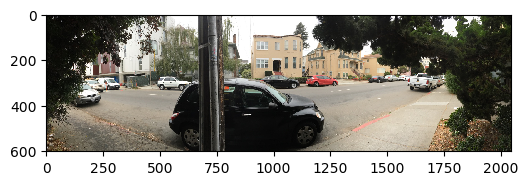

In [41]:
try:
    raw_images
except NameError:
    aca_raw_images, aca_min_h, aca_min_w = read_ims(aca_image_files)
    naca_raw_images, naca_min_h, naca_min_w = read_ims(naca_image_files)
    #use less of height and width to make samples square
    min_dim = min(aca_min_h, aca_min_w, naca_min_h, naca_min_w)
    
plt.imshow(aca_raw_images[20])

print('min image height: {}'.format(aca_min_h))
print('min image width: {}'.format(aca_min_w))

plt.imshow(naca_raw_images[20])

print('min image height: {}'.format(naca_min_h))
print('min image width: {}'.format(naca_min_w))

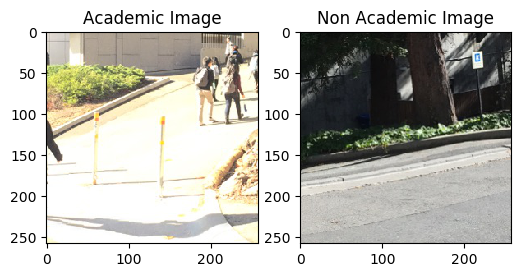

In [42]:
def cropims(ims,crop_h,crop_w,area):
    h_crop_h = np.int(crop_h/2)
    h_crop_w = np.int(crop_w/2)
    #newims = np.ones((np.shape(ims)[0],crop_h,crop_w,3))
    newims = []
    for i, im in enumerate(ims):
        #print(np.shape(im))
        im_h = np.shape(im)[0]
        im_w = np.shape(im)[1]
        h_im_h = np.int(im_h/2) #half image height
        h_im_w = np.int(im_w/2) #half image width
        if(area=='middle'):
            newim = im[h_im_h-h_crop_h:h_im_h+h_crop_h, #crop height
                       h_im_w-h_crop_w:h_im_w+h_crop_w, #crop width
                       :]
        elif(area=='top'):
             newim = im[0:crop_h, #crop height
                       h_im_w-h_crop_w:h_im_w+h_crop_w, #crop width
                       :]
        elif(area=='bottom'):
             newim = im[im_h-crop_h:im_h, #crop height
                       h_im_w-h_crop_w:h_im_w+h_crop_w, #crop width
                       :]
        else:
            raise ValueError('area not well specified!')
        #print(np.shape(newim))
        #newims[i,:,:,:] = newim
        newims.append(newim)
    return(newims)

aca_images_middle = cropims(aca_raw_images,min_dim,min_dim,'middle')
aca_images_top = cropims(aca_raw_images,min_dim,min_dim,'top')
aca_images_bottom = cropims(aca_raw_images,min_dim,min_dim,'bottom')
aca_images = aca_images_middle

sim = aca_images[21]
plt.subplot(1,2,1,title="Academic Image")
plt.imshow(sim)

naca_images_middle = cropims(naca_raw_images,min_dim,min_dim,'middle')
naca_images_top = cropims(naca_raw_images,min_dim,min_dim,'top')
naca_images_bottom = cropims(naca_raw_images,min_dim,min_dim,'bottom')
naca_images = naca_images_middle

plt.subplot(1,2,2,title="Non Academic Image")
plt.imshow(sim)

(-0.5, 257.5, 258.5, -0.5)

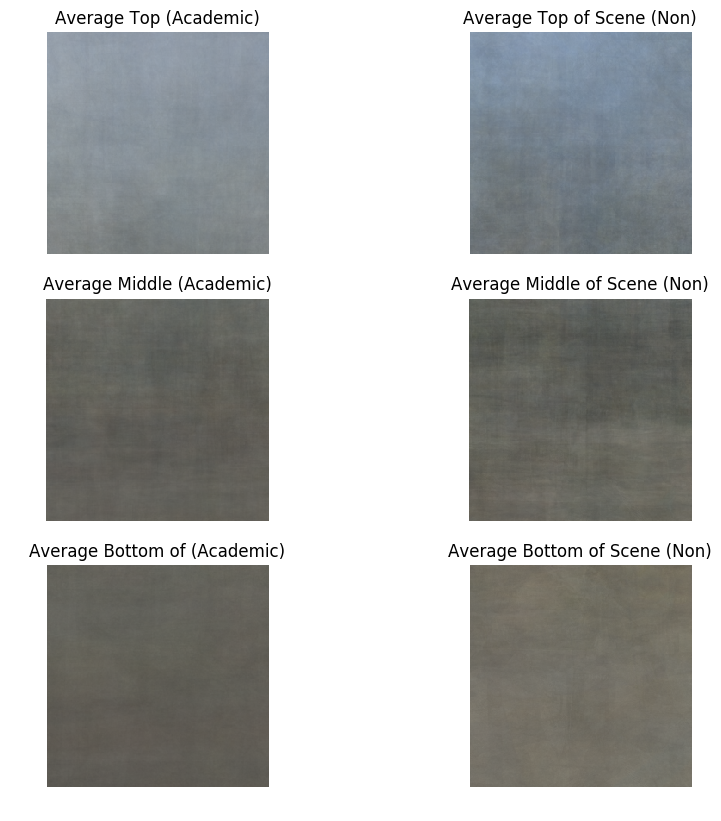

In [43]:
def avgims(ims):
    ims_arr = np.asarray(ims)
    #average images  - first index must be list of images
    avg = np.zeros_like(ims_arr[0])
    #print(np.shape(avg))
    for c in range(np.shape(avg)[2]): #loop over R, G, and B
        avg[:,:,c] = np.mean(ims_arr[:,:,:,c],axis=0)
    return(avg)

#non academic
naca_avgim = avgims(naca_images)
naca_avgim_top = avgims(naca_images_top)
naca_avgim_middle = avgims(naca_images_middle)
naca_avgim_bottom = avgims(naca_images_bottom)

#academic
aca_avgim = avgims(aca_images)
aca_avgim_top = avgims(aca_images_top)
aca_avgim_middle = avgims(aca_images_middle)
aca_avgim_bottom = avgims(aca_images_bottom)

plt.figure(figsize=(10,10))

plt.subplot(3,2,1,title='Average Top (Academic)')
plt.imshow(aca_avgim_top)
plt.axis('off')
plt.subplot(3,2,3,title='Average Middle (Academic)')
plt.imshow(aca_avgim_middle)
plt.axis('off')
plt.subplot(3,2,5,title='Average Bottom of (Academic)')
plt.imshow(aca_avgim_bottom)
plt.axis('off')

plt.subplot(3,2,2,title='Average Top of Scene (Non)')
plt.imshow(naca_avgim_top)
plt.axis('off')
plt.subplot(3,2,4,title='Average Middle of Scene (Non)')
plt.imshow(naca_avgim_middle)
plt.axis('off')
plt.subplot(3,2,6,title='Average Bottom of Scene (Non)')
plt.imshow(naca_avgim_bottom)
plt.axis('off')

In [44]:
def spatialft(image):
    # Take the fourier transform of the image.
    # shift the quadrants around so that low spatial frequencies are in
    # the center of the 2D fourier transformed image
    greyavgim = np.mean(np.asarray(image),axis=2) #average over colors
    greyavgim =  greyavgim - np.mean(greyavgim) #remove DC component
    ft = np.abs(np.fft.fftshift(np.fft.fft2(greyavgim)))
    fqs = [np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[0])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[1]))]
    ps = ft**2
    return(greyavgim, ft, ps, fqs)

def get_logspace_contours(raw_field):
    # Get the contour locations by percentage
    log_field = np.log10(raw_field)
    field = log_field/log_field.sum()
    n = 1000
    t = np.linspace(0, field.max(), n)
    integral = ((field >= t[:, None, None]) * field).sum(axis=(1,2))
    f = interpolate.interp1d(integral, t)
    t_contours = f(c_levels)*log_field.sum()
    linear_t_contours = 10**t_contours
    return(linear_t_contours)

def fit_alpha_as(set_ims, set_avgim):
    
    #1/f function to fit
    def feq(cpd, a, alpha):
        amp = a/(cpd**alpha)
        return(amp)
    
    #data to fit function to
    minfit = alpha_a_fitrange[0]
    maxfit = alpha_a_fitrange[1]
    
    #initialize values
    xs_vert = []
    ys_vert = []
    xs_horz = []
    ys_horz = []
    xs_skew = []
    ys_skew = []
    
    #cacluate ft and fit values for each image, so we have many points to fit
    for i, im in enumerate(set_ims):
        normim = im/np.max(set_avgim) #normalize our image
        im_bw, ft2d, ps2d, fqs = spatialft(normim) #calculate the fourier transform
        #vertical
        minfq_v = np.abs(fqs[1] - minfit).argmin() #which VERTICAL frequency is closest to the min we want (index)?
        maxfq_v = np.abs(fqs[1] - maxfit).argmin() #whcih VERTICAL frequency is closest to the max we want (index)?
        xs_vert.append(fqs[1][minfq_v:maxfq_v]) #add our values for VERTICAL frequencies between these limits
        ys_vert.append(ft2d[int(np.shape(ft2d)[0]/2),minfq_v:maxfq_v]) #add our values for VERTICAL fourier amps in this limit
        #horizontal
        minfq_h = np.abs(fqs[0] - minfit).argmin() #index of horiz frequency closest to range
        maxfq_h = np.abs(fqs[0] - maxfit).argmin() #index of horiz frequency closest to range
        xs_horz.append(fqs[0][minfq_h:maxfq_h]) #horiz fqs in these limits
        ys_horz.append(ft2d[minfq_h:maxfq_h,int(np.shape(ft2d)[1]/2)]) #hoirz fourier amps in range
        #skew #TODO: CODE SKEW CALC OUT
        skewfqs = np.sqrt(np.add(fqs[0][-int(np.shape(ft2d)[0]/2):]**2,
                                 fqs[1][-int(np.shape(ft2d)[0]/2):]**2)) #use x index here [0] to ensure same size
        #skew frequncies diagonally out from middle by pythagorean therom ASSUME EQUALLY SPACED                                                                                                                                                                                                                                                                                                                                                                                                                                                      
        minfq_s = np.abs(skewfqs - minfit).argmin() #index of skew fq closest to range
        maxfq_s = np.abs(skewfqs - maxfit).argmin() #index of skew fq closest to range
        #print(skewfqs)
        #print(minfq_s, maxfq_s)
        xs_skew.append(skewfqs[minfq_s:maxfq_s])
        ys_skew.append(np.diagonal(ft2d[int(np.shape(ft2d)[0]/2)+minfq_s:int(np.shape(ft2d)[0]/2)+maxfq_s, 
                            int(np.shape(ft2d)[1]/2)+minfq_s:int(np.shape(ft2d)[1]/2)+maxfq_s])) #start from middle to measure fqs
        
    #vertical
    [a_vert, alpha_vert],vert_cov = scipy.optimize.curve_fit(feq,
                                                             np.array(xs_vert).flatten(),
                                                             np.array(ys_vert).flatten())
    [a_vert_se,alpha_vert_se] = np.sqrt(np.diag(vert_cov)) #convert to 1 SD
    
    #horizontal
    [a_horz, alpha_horz], horz_cov = scipy.optimize.curve_fit(feq,
                                                             np.array(xs_horz).flatten(),
                                                             np.array(ys_horz).flatten())
    [a_horz_se,alpha_horz_se] = np.sqrt(np.diag(horz_cov)) #convert to 1 SD

    #skew
    [a_skew, alpha_skew], skew_cov = scipy.optimize.curve_fit(feq,
                                                               np.array(xs_skew).flatten(),
                                                               np.array(ys_skew).flatten())
    [a_skew_se,alpha_skew_se] = np.sqrt(np.diag(skew_cov))

    
    a_vhs_exp = [a_vert,a_horz,a_skew]
    a_vhs_se = [a_vert_se,a_horz_se,a_skew_se]
    alpha_vhs_exp = [alpha_vert,alpha_horz,alpha_skew]
    alpha_vhs_se = [alpha_vert_se,alpha_horz_se,alpha_skew_se]

    return(a_vhs_exp, a_vhs_se, alpha_vhs_exp, alpha_vhs_se)


def interp_get_contours(ps):
    interp = scipy.ndimage.filters.gaussian_filter(ps,interp_val)
    contours = get_logspace_contours(interp)
    return(interp, contours)

def contour_plotter(im,ps,fqs):
    #function to make contour plots
    interp, contours = interp_get_contours(ps)
    cont_pl = plt.pcolormesh(fqs[1],fqs[0],interp, cmap="gray", norm=mpl.colors.LogNorm())#,extent=extents)
    cont_pl = plt.colorbar()
    pl = plt.contour(fqs[1],fqs[0],interp,levels=contours, cmap=c_cmap, norm = mpl.colors.LogNorm())
    return(pl)

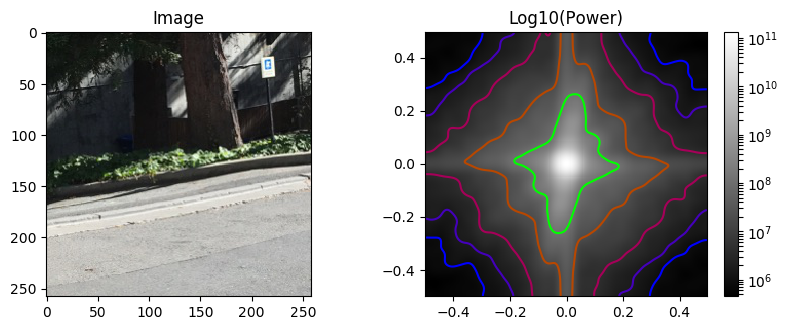

In [45]:
#2d power spectra
plt.figure(figsize=(10, 3.5))
plt.subplots(nrows=1,ncols=2,figsize =(10,3.5))
plt.subplot(1,2,1,title='Image')
plt.imshow(sim, interpolation='none',cmap='gray')
plt.subplot(1,2,2,title='Log10(Power)')
simage, ft2d, ps2d, sfqs = spatialft(sim)
contour_plotter(simage,ps2d,sfqs)

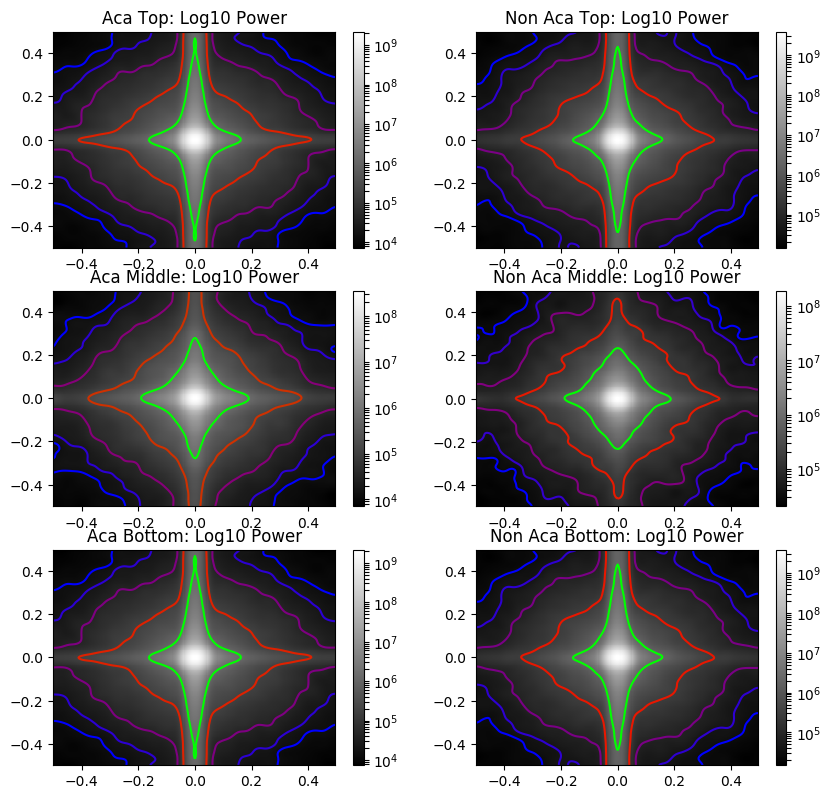

In [10]:
#2d power spectra
plt.figure(figsize=(10, 20))

#AVERAGE TOP
#ACA
image_top, ft2d_top, ps2d_top, fqs_top = spatialft(aca_avgim_top)
plt.subplot(6,2,1,title='Aca Top: Log10 Power')
#plt.imshow(image_top, interpolation='none',cmap='gray')
contour_plotter(image_top,ps2d_top,fqs_top)
#NON ACA
image_top, ft2d_top, ps2d_top, fqs_top = spatialft(naca_avgim_top)
plt.subplot(6,2,2,title='Non Aca Top: Log10 Power')
#plt.imshow(image_top, interpolation='none',cmap='gray')
contour_plotter(image_top,ps2d_top,fqs_top)

#AVERAGE Middle
#ACA
image_middle, ft2d_middle, ps2d_middle, fqs_middle = spatialft(aca_avgim_middle)
plt.subplot(6,2,3,title='Aca Middle: Log10 Power')
#plt.imshow(image_top, interpolation='none',cmap='gray')
contour_plotter(image_middle,ps2d_middle,fqs_middle)
#NON ACA
image_middle, ft2d_middle, ps2d_middle, fqs_middle = spatialft(naca_avgim_bottom)
plt.subplot(6,2,4,title='Non Aca Middle: Log10 Power')
#plt.imshow(image_top, interpolation='none',cmap='gray')
contour_plotter(image_middle,ps2d_middle,fqs_middle)

#AVERAGE Bottom
#ACA
image_bottom, ft2d_bottom, ps2d_bottom, fqs_bottom = spatialft(aca_avgim_top)
plt.subplot(6,2,5,title='Aca Bottom: Log10 Power')
#plt.imshow(image_top, interpolation='none',cmap='gray')
contour_plotter(image_bottom,ps2d_bottom,fqs_bottom)
#NON ACA
image_bottom, ft2d_bottom, ps2d_bottom, fqs_bottom = spatialft(naca_avgim_top)
plt.subplot(6,2,6,title='Non Aca Bottom: Log10 Power')
#plt.imshow(image_top, interpolation='none',cmap='gray')
contour_plotter(image_bottom,ps2d_bottom,fqs_bottom)

In [11]:
## summary plots

aca_top_a, aca_top_a_dev, aca_top_alpha, aca_top_alpha_dev = fit_alpha_as(aca_images_top, aca_avgim_top)
aca_middle_a, aca_middle_a_dev,aca_middle_alpha, aca_middle_alpha_dev = fit_alpha_as(aca_images_middle, aca_avgim_middle)
aca_bottom_a, aca_bottom_a_dev,aca_bottom_alpha, aca_bottom_alpha_dev = fit_alpha_as(aca_images_bottom, aca_avgim_bottom)

naca_top_a, naca_top_a_dev, naca_top_alpha, naca_top_alpha_dev = fit_alpha_as(naca_images_top, naca_avgim_top)
naca_middle_a, naca_middle_a_dev,naca_middle_alpha, naca_middle_alpha_dev = fit_alpha_as(naca_images_middle, naca_avgim_middle)
naca_bottom_a, naca_bottom_a_dev,naca_bottom_alpha, naca_bottom_alpha_dev = fit_alpha_as(naca_images_bottom, naca_avgim_bottom)

a_alpha_fits = pd.DataFrame([['a', 'vertical','top',aca_top_a[0], naca_top_a[0]],
                             ['a', 'vertical','middle',aca_middle_a[0],naca_middle_a[0]],
                             ['a', 'vertical','bottom',aca_bottom_a[0],naca_bottom_a[0]],
                             ['a', 'horizontal','top', aca_top_a[1],naca_top_a[1]],
                             ['a', 'horizontal','middle', aca_middle_a[1],naca_middle_a[1]],
                             ['a', 'horizontal','bottom', aca_bottom_a[1],naca_bottom_a[1]],                        
                             ['a', 'skew', 'top', aca_top_a[2], naca_top_a[2]],
                             ['a', 'skew', 'middle', aca_middle_a[2], naca_middle_a[2]],
                             ['a', 'skew', 'bottom', aca_bottom_a[2], naca_bottom_a[2]],
                             ['a_se', 'vertical','top', aca_top_a_dev[0],naca_top_a_dev[0]],
                             ['a_se', 'vertical', 'middle', aca_middle_a_dev[0],naca_middle_a_dev[0]],
                             ['a_se', 'vertical', 'bottom', aca_bottom_a_dev[0],naca_bottom_a_dev[0]],
                             ['a_se', 'horizontal','top', aca_top_a_dev[1],naca_top_a_dev[1]],
                             ['a_se', 'horizontal','middle', aca_middle_a_dev[1],naca_middle_a_dev[1]],
                             ['a_se', 'horizontal','bottom', aca_bottom_a_dev[1],naca_bottom_a_dev[1]],
                             ['a_se', 'skew', 'top', aca_top_a_dev[2], naca_top_a_dev[2]],
                             ['a_se', 'skew', 'middle', aca_middle_a_dev[2], naca_middle_a_dev[2]],
                             ['a_se', 'skew', 'bottom', aca_bottom_a_dev[2], naca_bottom_a_dev[2]],
                             ['alpha', 'vertical', 'top', aca_top_alpha[0],naca_top_alpha[0]],
                             ['alpha', 'vertical', 'middle', aca_middle_alpha[0],naca_middle_alpha[0]],
                             ['alpha', 'vertical', 'bottom', aca_bottom_alpha[0],naca_bottom_alpha[0]],
                             ['alpha', 'horizontal', 'top', aca_top_alpha[1],naca_top_alpha[1]],
                             ['alpha', 'horizontal', 'middle', aca_middle_alpha[1],naca_middle_alpha[1]],
                             ['alpha', 'horizontal', 'bottom', aca_bottom_alpha[1],naca_bottom_alpha[1]],
                             ['alpha', 'skew', 'top', aca_top_alpha[2], naca_top_alpha[2]],
                             ['alpha', 'skew', 'middle', aca_middle_alpha[2], naca_middle_alpha[2]],
                             ['alpha', 'skew', 'bottom', aca_bottom_alpha[2], naca_bottom_alpha[2]],      
                             ['alpha_se', 'vertical', 'top', aca_top_alpha_dev[0],naca_top_alpha_dev[0]],
                             ['alpha_se', 'vertical', 'middle', aca_middle_alpha_dev[0],naca_middle_alpha_dev[0]],
                             ['alpha_se', 'vertical', 'bottom', aca_bottom_alpha_dev[0],naca_bottom_alpha_dev[0]],
                             ['alpha_se', 'horizontal', 'top', aca_top_alpha_dev[1],naca_top_alpha_dev[1]],
                             ['alpha_se', 'horizontal', 'middle', aca_middle_alpha_dev[1],naca_middle_alpha_dev[1]],
                             ['alpha_se', 'horizontal', 'bottom', aca_bottom_alpha_dev[1],naca_bottom_alpha_dev[1]],
                             ['alpha_se', 'skew', 'top', aca_top_alpha_dev[2], naca_top_a_dev[2]],
                             ['alpha_se', 'skew', 'middle', aca_middle_alpha_dev[2], naca_middle_alpha_dev[2]],
                             ['alpha_se', 'skew', 'bottom', aca_bottom_alpha_dev[2], naca_bottom_alpha_dev[2]]
                             ])
a_alpha_fits.columns = ['variable','direction','scene portion','aca','non_aca']
a_alpha_fits

,variable,direction,scene portion,aca,non_aca
0,a,vertical,top,11.766810,12.409202
1,a,vertical,middle,19.417231,16.484391
2,a,vertical,bottom,10.044251,7.501336
3,a,horizontal,top,16.429062,12.964322
4,a,horizontal,middle,28.419514,28.838080
5,a,horizontal,bottom,16.179585,15.676919
6,a,skew,top,2.089638,2.283249
7,a,skew,middle,3.946495,3.870500
8,a,skew,bottom,3.259813,2.374119
9,a_se,vertical,top,0.505339,0.658047


array([<matplotlib.axes._subplots.AxesSubplot object at 0x129094908>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1290f9da0>], dtype=object)

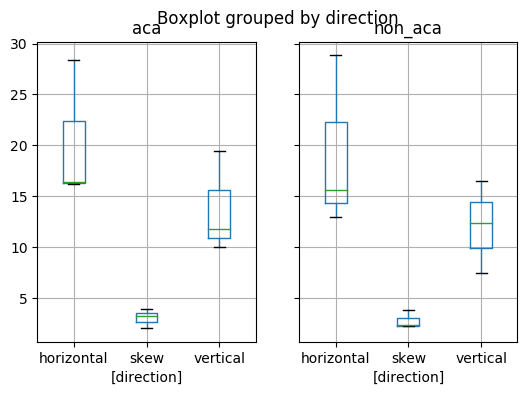

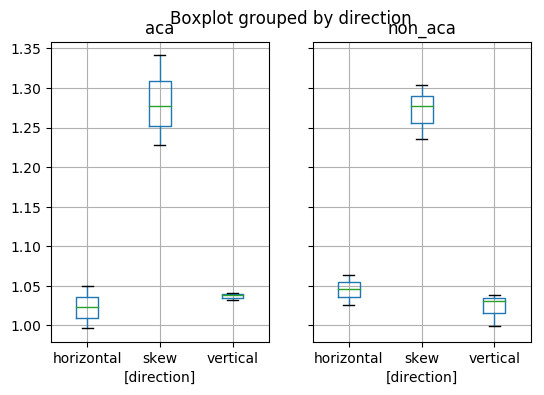

In [12]:
alpha = a_alpha_fits[(a_alpha_fits.variable == 'alpha')]
a = a_alpha_fits[(a_alpha_fits.variable == 'a')]

plt.figure()
a.boxplot(by=['direction'])
alpha.boxplot(by=['direction'])

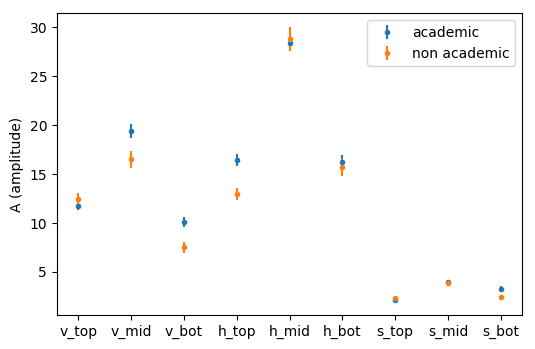

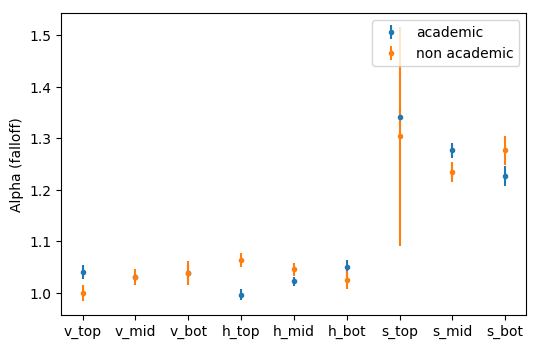

In [13]:
a_aca_vals = a['aca']
a_aca_sds = a_alpha_fits[(a_alpha_fits.variable == 'a_se')]['aca']
a_naca_vals = a['non_aca']
a_naca_sds = a_alpha_fits[(a_alpha_fits.variable == 'a_se')]['non_aca']

alpha_aca_vals = alpha['aca']
alpha_aca_sds = a_alpha_fits[(a_alpha_fits.variable == 'alpha_se')]['aca']
alpha_naca_vals = alpha['non_aca']
alpha_naca_sds = a_alpha_fits[(a_alpha_fits.variable == 'alpha_se')]['non_aca']

plt.figure()
plt.errorbar(np.arange(9),a_aca_vals,a_aca_sds,label='academic',fmt='.')
plt.errorbar(np.arange(9),a_naca_vals,a_naca_sds,label='non academic',fmt='.')
plt.ylabel('A (amplitude)')
plt.xticks(np.arange(9),['v_top', 'v_mid', 'v_bot', 'h_top', 'h_mid', 'h_bot', 's_top', 's_mid', 's_bot'])
plt.legend()

plt.figure()
plt.errorbar(np.arange(9),alpha_aca_vals,alpha_aca_sds,label='academic',fmt='.')
plt.errorbar(np.arange(9),alpha_naca_vals,alpha_naca_sds,label='non academic',fmt='.')
plt.ylabel('Alpha (falloff)')
plt.xticks(np.arange(9),['v_top', 'v_mid', 'v_bot', 'h_top', 'h_mid', 'h_bot', 's_top', 's_mid', 's_bot'])

plt.legend()

In [62]:
np.shape(subjects)

(41,)

In [61]:
## Calculate for individual subjects

sub_avgims = []

sub_avgims_bw = []
sub_avgps2ds = []
sub_avgfqs = []

sub_alphas = []
sub_alphas_dev = []
sub_as = []
sub_as_dev = []

sub_xls_files = []
#sub_mean_axiallen_OS = []
#sub_mean_axiallen_OD = []

###TODO: index for subjects as readin from excel file is not consistent with order in fileread - FIX THISes

#go through each unique subjectl and pull out their images
for i, usub in enumerate(subjects):
    #get lists of subject images
    aca_sub_idxs = [i for i,x in enumerate(aca_image_files) if usub in x]
    naca_sub_idxs = [i for i,x in enumerate(naca_image_files) if usub in x]
    aca_subims = np.array(aca_images)[aca_sub_idxs]
    naca_subims = np.array(naca_images)[naca_sub_idxs]


In [18]:
 
    #average images
    sub_avgim = avgims(subims)
    sub_avgims.append(sub_avgim)
    
    #power spectrum
    sub_avgim_bw, sub_ft2d, s56tub_ps2d, sub_fqs = spatialft(sub_avgim)
    sub_avgims_bw.append(sub_avgim_bw)
    sub_avgps2ds.append(sub_ps2d)
    sub_avgfqs.append(sub_fqs)
    
    #alphas and a fits
    sub_a, sub_a_dev,sub_alpha, sub_alpha_dev = fit_alpha_as(subims, sub_avgim)
    sub_alphas.append(sub_alpha)
    sub_alphas_dev.append(sub_alpha_dev)
    sub_as.append(sub_a)
    sub_as_dev.append(sub_a_dev)
    
    #axial length
    #academic axial length
    sub_al = df_aca[df_aca['SID']==usub]['AL_OD']
    #print(usub)
    #print(np.float(sub_al))
    sub_axiallen_aca.append(np.float(sub_al))
    #nonacademic axial length
    #sub_al = df_nonaca.AL_OD[df.SID==subid]
    #sub_axiallen_nonaca.append(sub_al)
#print(np.shape(sub_axiallen_aca))
    #OD axis len
    #axis_reads_od = df.Axis[df.Eye=='OD']
    #axis_reads_od = axis_reads_od[axis_reads_od>10] #reads below 20 are obviously wrong
#    sub_mean_axiallen_OD.append(np.mean(axis_reads_od))
    #OS axis len
    #axis_reads_os = df.Axis[df.Eye=='OS']
    #axis_reads_os = axis_reads_os[axis_reads_os>10] #reads below 20 are obviously wrong
#    sub_mean_axiallen_OS.append(np.mean(axis_reads_os))
    
#sub_as = sub_as/np.mean(sub_as,axis=0)

IndentationError: unexpected indent (<ipython-input-18-2b347d1855ef>, line 3)

In [ ]:
#plot 2d power spectra for 3 random subjects
trs = np.random.choice(np.arange(len(sub_avgims)),3,replace=False)

plt.subplots(nrows=2,ncols=4,figsize =(8,10))

idx = trs[0]
plt.subplot(3,2,1,title='Avg: {}'.format(usubs[idx]))
plt.imshow(sub_avgims[idx], interpolation='none',cmap='gray')
plt.subplot(3,2,2,
            title=r'$A_v={0:.1f},\alpha_v={1:.1f},A_h={2:.1f},\alpha_h={3:.1f}$'.format(sub_as[idx][0],
                                                                                       sub_alphas[idx][0],
                                                                                       sub_as[idx][1], 
                                                                                       sub_alphas[idx][1])
            )
contour_plotter(sub_avgims[idx],sub_avgps2ds[idx],sub_avgfqs[idx])

idx = trs[1]
plt.subplot(3,2,3,title='Avg: {}'.format(usubs[idx]))
plt.imshow(sub_avgims[idx], interpolation='none',cmap='gray')
plt.subplot(3,2,4,
            title=r'$A_v={0:.1f},\alpha_v={1:.1f},A_h={2:.1f},\alpha_h={3:.1f}$'.format(sub_as[idx][0],
                                                                                       sub_alphas[idx][0],
                                                                                       sub_as[idx][1], 
                                                                                       sub_alphas[idx][1])
            )
contour_plotter(sub_avgims[idx],sub_avgps2ds[idx],sub_avgfqs[idx])

idx = trs[2]
plt.subplot(3,2,5,title='Avg: {}'.format(usubs[trs[2]]))
plt.imshow(sub_avgims[idx], interpolation='none',cmap='gray')
plt.subplot(3,2,6,
            title=r'$A_v={0:.1f},\alpha_v={1:.1f},A_h={2:.1f},\alpha_h={3:.1f}$'.format(sub_as[idx][0],
                                                                                       sub_alphas[idx][0],
                                                                                       sub_as[idx][1], 
                                                                                       sub_alphas[idx][1])
            )

contour_plotter(sub_avgims_bw[idx],sub_avgps2ds[idx],sub_avgfqs[idx])

In [ ]:
d=np.column_stack((np.asarray(sub_alphas)[:,0],
                   np.asarray(sub_alphas_dev)[:,0],
                   np.asarray(sub_as)[:,0],
                   np.asarray(sub_as_dev)[:,0],
                   
                   np.asarray(sub_alphas)[:,1],
                   np.asarray(sub_alphas_dev)[:,1],
                   np.asarray(sub_as)[:,1],
                   np.asarray(sub_as_dev)[:,1],
                   
                   #skew
#                  np.asarray(sub_alphas)[:,2],
#                  np.asarray(sub_alphas_dev)[:,2],
#                  np.asarray(sub_as)[:,2],
#                  np.asarray(sub_as_dev)[:,2])
                
                   np.asarray(sub_axiallen_aca),
                   
                  np.asarray(np.asarray(sub_alphas)[:,0]/np.asarray(sub_alphas)[:,1]),
                  np.asarray(np.asarray(sub_as)[:,0]/np.asarray(sub_as)[:,1]),
                  ))

#ix3 = pd.MultiIndex.from_arrays([['a', 'a', 'a', 'a', 'b', 'b', 'b', 'b'], ['foo', 'foo', 'bar', 'bar', 'foo', 'foo', 'bar', 'bar']], names=['letter', 'word'])

dfdatas = ['alp_v','alp_v_SD','A_v','A_v_SD',
           'alp_h','alp_h_SD','A_h','A_h_SD',
#          'alp_s','alp_s_SD','A_s','A_s_SD', #skew
           'axial_len_OD',
           'alpha_vh_ratio',
           'A_vh_ratio'
           
          ]

df = pd.DataFrame(d,
                  index=usubs,
                  columns=dfdatas)
df.round(2)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize =(7,6))
means = df[['alp_v','alp_h']]
means.columns=['vertical','horizontal']
sds = df[['alp_v_SD','alp_h_SD']]
sds.columns=['vertical','horizontal']
means.plot.bar(yerr=sds, ax=axes[0], colormap='viridis')

axes[0].set_title('Alpha Fits')
axes[0].get_xaxis().set_visible(False)

means = df[['A_v','A_h']]
means.columns=['vertical','horizontal']
sds = df[['A_v_SD','A_h_SD']]
sds.columns=['vertical','horizontal']
means.plot.bar(yerr=sds,ax=axes[1],colormap='viridis')

axes[1].set_title('A Fits')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(12,4))

#x = np.array(df.alp_h,df.alp_h[~np.isnan(df.axial_len_OD)])
#y = np.array(df.alp_v,df.alp_v[~np.isnan(df.axial_len_OD)])
#z = np.array(df.axial_len_OS,df.axial_len_OD[~np.isnan(df.axial_len_OD)])

#plt.plot(x,y,c=z)
#plt.scatter(df.alp_h, df.alp_v)#axial_len_OS',cmap='Greens')
df.plot.scatter(x='alp_h',y='alp_v', c='axial_len_OD',colormap='Greens',s=80,ax=axes[0])
axes[0].set_title('Axial Length and Alpha')

#df.plot.scatter(df.A_h, df.A_v)#colormap='Greens',s=80,ax=axes[1])
df.plot.scatter(x='A_h',y='A_v', c='axial_len_OD',colormap='Greens',s=80,ax=axes[1])
axes[1].set_title('Axial Length and A')

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2
                         , figsize =(9,9))

df.plot.scatter(x='alp_h',y='axial_len_OD',c='green',s=80,ax=axes[0,0])

x = df.alp_h
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[0,0].plot(xlsp,ylsp,'g')
axes[0,0].plot(xlsp,ylsp+se,'b-.')
axes[0,0].plot(xlsp,ylsp-se,'b-.')
axes[0,0].set_title('Axial Len and Horizo Alpha,r^2={}'.format(np.round(rsq,1)))


df.plot.scatter(x='alp_v',y='axial_len_OD',c='green',s=80,ax=axes[0,1])
#fit a line
x = df.alp_v
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[0,1].plot(xlsp,ylsp,'g')
axes[0,1].plot(xlsp,ylsp+se,'b-.')
axes[0,1].plot(xlsp,ylsp-se,'b-.')
axes[0,1].set_title('Axial Len and Vert Alpha, r^2={}'.format(np.round(rsq,1)))


df.plot.scatter(x='alp_h',y='axial_len_OD',c='green',s=80,ax=axes[1,0])

x = df.A_h
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[1,0].plot(xlsp,ylsp,'g')
axes[1,0].plot(xlsp,ylsp+se,'b-.')
axes[1,0].plot(xlsp,ylsp-se,'b-.')
axes[1,0].set_title('Axial Len and Horiz Amp, r^2={}'.format(np.round(rsq,1)))


df.plot.scatter(x='A_v',y='axial_len_OD',c='green',s=80,ax=axes[1,1])
#fit a line
x = df.A_v
y = df.axial_len_OD

z = np.polyfit(x,y,deg=1,full=True) #FITTING ONLY TO OS!!!
m_h = z[0][0]
b_h = z[0][1]
sse = z[1]#[0]
rsq = 1-sse/np.sum((y-np.mean(y))**2)
fit = np.array(m_h*x+b_h)
err_h = np.abs(y-fit)
se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
sem = se/np.sqrt(len(x))
xlsp = np.linspace(np.min(x), np.max(x),50)
ylsp = xlsp*m_h+b_h
axes[1,1].plot(xlsp,ylsp,'g')
axes[1,1].plot(xlsp,ylsp+se,'b-.')
axes[1,1].plot(xlsp,ylsp-se,'b-.')
axes[1,1].set_title('Axial Len and Vert Amp, r^2={}'.format(np.round(rsq,1)))


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(12,4))

axes[0,0].set_title('Axial Length and Alpha')

df.plot.scatter(x='A_vh_ratio', y='axial_len_OD',s=80,ax=axes[0,1],c='green')

axes[0,1].set_title('Axial Length and A')

In [ ]:
df.plot.scatter(x='alpha_vh_ratio',y='axial_len_OD',s=80,c='green')


In [ ]:
df.plot.scatter(x='A_vh_ratio', y='axial_len_OD',s=80,c='green')
